## Shortlist Promising Models - SGD Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
from module.utils import model_performance_utils
import module.utils.bin_class_utils as bin_class_utils

from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
target_attr = "label"
target_type = "binary"

estimator_name = "SGDClassifier"

sample_random_state = 24
target_encoding_random_state = 42
model_random_state = 42
loss = 'log_loss'
permutation_importance_random_state = 0
train_validation_split_random_state = 24

#### 1. Import Data

In [3]:
train_df = pd.read_csv('train_df_exp.csv')
train_df

,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1266565,2325,4456,6,139,60,3,17,78,23,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,38,7,0
1,2003072,3456,3720,7,107,15,5,15,46,39,...,2,18,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,36,3,0
2,1648461,3854,3367,7,207,17,5,14,13,37,...,5,20,1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
3,1829479,3330,6897,7,133,37,5,13,34,13,...,4,20,1,-1,2,1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^1...,12,17,1,0
4,2139990,1464,5117,7,119,60,5,12,57,27,...,3,16,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,11,24,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,1435115,1054,1325,7,147,29,5,17,86,37,...,5,18,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,17,1,0
6700,2126988,3420,4680,8,142,36,5,12,80,41,...,2,-1,-1,-1,2,1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^1...,12,42,1,0
6701,1440508,5295,2402,7,147,29,5,12,86,37,...,4,-1,-1,-1,2,8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,8,17,4,0
6702,2214417,1007,6572,7,145,46,5,17,43,37,...,3,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,12,27,6,0


In [9]:
train_cap_x_df, train_y_df = train_df.drop(columns=target_attr), train_df[target_attr]

In [10]:
print('Distribution in train_y_df\n', train_y_df.value_counts(normalize=True), '\n')

Distribution in train_y_df
 label
0    0.965543
1    0.034457
Name: proportion, dtype: float64 



#### 3. Check attribute types

In [11]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_df.columns if attr not in numerical_attr_list and attr != target_attr]
attr_list = numerical_attr_list + categorical_attr_list

#### ! Unbalance
- Assess unbalance: Based on the distribution printed above, the distribution is unbalanced. 
- Steps to deal with unbalanced classes

In [12]:
# possible options for class_weight hyperparameter
balanced = train_y_df.shape[0] / (train_y_df.nunique()*np.bincount(train_y_df))
balanced_dict = \
   dict(
       zip(
           train_y_df.unique(), 
           balanced
       )
   )
balanced_and_normalized_dict = \
    dict(
        zip(
            train_y_df.unique(),
            balanced/sum(balanced)
            )
        )
class_weight_options_dict = {
    'None': None,
    'balanced mode': 'balanced',
    'balanced computed': balanced_dict,
    'balanced_and_normalized': balanced_and_normalized_dict
}

#### 4. Predefined data processing strategy in prep.ipynb

In [13]:
attrs_to_drop = ['app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id', 'app_second_class', 'adv_prim_id', 'device_price']


preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop, target_type, target_encoding_random_state)

#### 5. Define default model

In [24]:
estimator = SGDClassifier(loss=loss, random_state=model_random_state)

#### 6. Define composite model

In [25]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])

In [26]:
composite_estimator.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id',
                                                                                                         'app_second_class',
                                                                                                         'adv_prim_id',
                                                                                                         'device_price'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical'...
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', SGDClassifier(loss='log_loss', random_state=42))])

#### 7. Check the most significant attributes

In [27]:
permutation_df = bin_class_utils.check_out_permutation_importance(
    composite_estimator, 
    train_cap_x_df, 
    train_y_df, 
    permutation_importance_random_state
)

permutation_df


Permutation importance:


,Feature,sqrt_neg_mean_squared_error
0,uid,0.067 +/- 0.024
1,device_name,0.040 +/- 0.017
2,device_size,0.036 +/- 0.012
3,his_app_size,0.033 +/- 0.012
4,slot_id,0.030 +/- 0.018
5,indu_name,0.028 +/- 0.016
6,app_first_class,0.026 +/- 0.016
7,creat_type_cd,0.024 +/- 0.015
8,residence,0.020 +/- 0.011


#### 8. Evaluate the performance of the trained default estimators on the train set
Based on the confusion matrix, 7976 (7976 + 0) predictions are correct and 404 (289 + 115) predictions are incorrect. - modify required

Check accuracy score
train set set accuracy score: 0.969272076372315

Check confusion matrix
train set set confusion matrix: 
[[6473    0]
 [ 206   25]]
True Positives =  6473
True Negatives =  25
False Positives(Type I error) =  0
False Negatives(Type II error) =  206

Check classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6473
           1       1.00      0.11      0.20       231

    accuracy                           0.97      6704
   macro avg       0.98      0.55      0.59      6704
weighted avg       0.97      0.97      0.96      6704


Check the ROC Curve and AUC


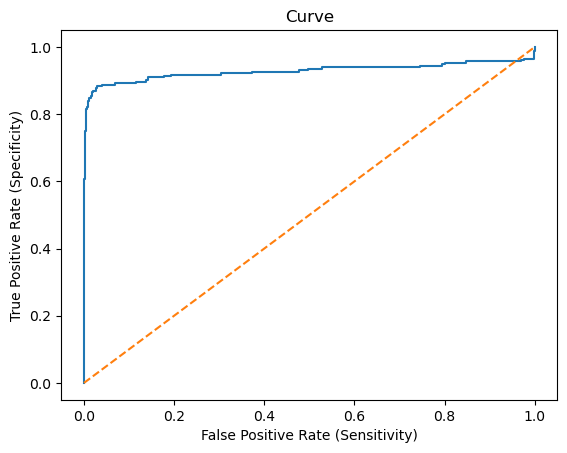


Check Precision-Recall Curve and Average Precision Score


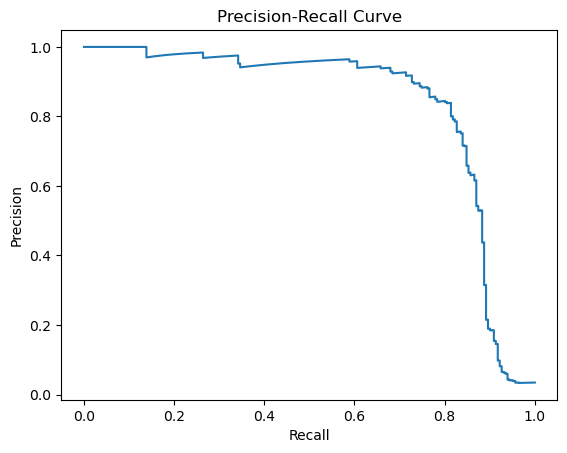

The roc_auc_score:  0.5541125541125541
Average Precision Score:  0.8362950142775036


(0.5541125541125541, 0.8362950142775036)

In [28]:
bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, 'train set')

#### 9. Performance with different class_weight hyperparameter

************************************************************

class_weight None
Check accuracy score
train sample set accuracy score: 0.969272076372315

Check confusion matrix
train sample set confusion matrix: 
[[6473    0]
 [ 206   25]]
True Positives =  6473
True Negatives =  25
False Positives(Type I error) =  0
False Negatives(Type II error) =  206

Check classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6473
           1       1.00      0.11      0.20       231

    accuracy                           0.97      6704
   macro avg       0.98      0.55      0.59      6704
weighted avg       0.97      0.97      0.96      6704


Check the ROC Curve and AUC


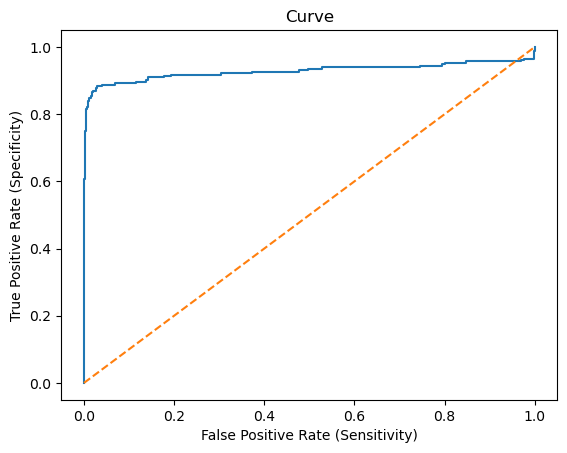


Check Precision-Recall Curve and Average Precision Score


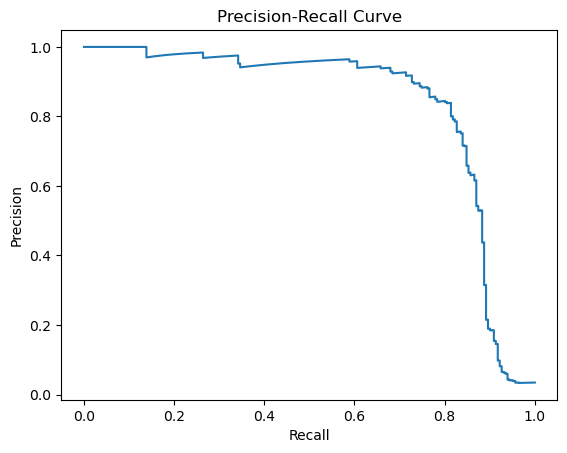

The roc_auc_score:  0.5541125541125541
Average Precision Score:  0.8362950142775036
************************************************************

class_weight balanced mode
Check accuracy score
train sample set accuracy score: 0.7765513126491647

Check confusion matrix
train sample set confusion matrix: 
[[4975 1498]
 [   0  231]]
True Positives =  4975
True Negatives =  231
False Positives(Type I error) =  1498
False Negatives(Type II error) =  0

Check classification report
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      6473
           1       0.13      1.00      0.24       231

    accuracy                           0.78      6704
   macro avg       0.57      0.88      0.55      6704
weighted avg       0.97      0.78      0.85      6704


Check the ROC Curve and AUC


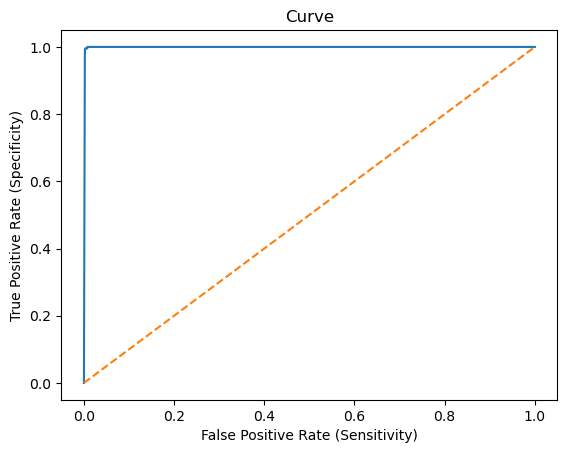


Check Precision-Recall Curve and Average Precision Score


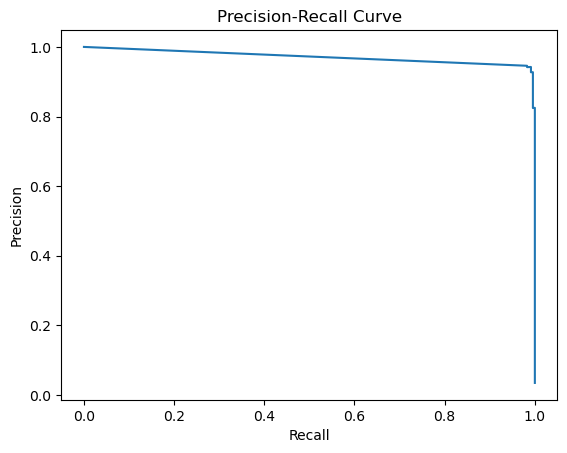

The roc_auc_score:  0.8842885833462073
Average Precision Score:  0.945199660662821
************************************************************

class_weight balanced computed
Check accuracy score
train sample set accuracy score: 0.7765513126491647

Check confusion matrix
train sample set confusion matrix: 
[[4975 1498]
 [   0  231]]
True Positives =  4975
True Negatives =  231
False Positives(Type I error) =  1498
False Negatives(Type II error) =  0

Check classification report
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      6473
           1       0.13      1.00      0.24       231

    accuracy                           0.78      6704
   macro avg       0.57      0.88      0.55      6704
weighted avg       0.97      0.78      0.85      6704


Check the ROC Curve and AUC


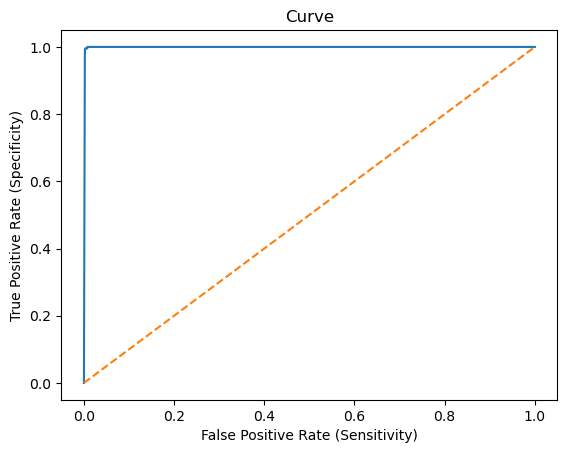


Check Precision-Recall Curve and Average Precision Score


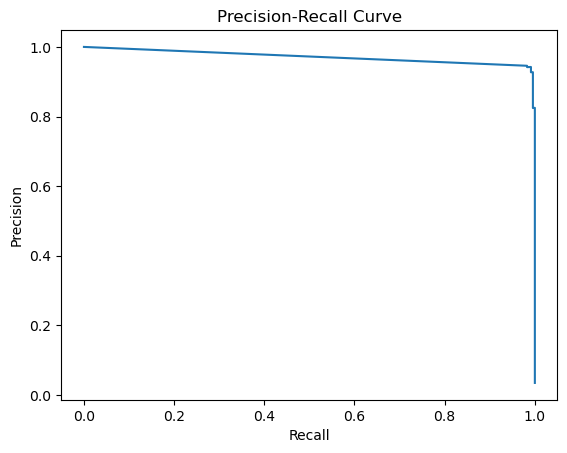

The roc_auc_score:  0.8842885833462073
Average Precision Score:  0.945199660662821
************************************************************

class_weight balanced_and_normalized
Check accuracy score
train sample set accuracy score: 0.9254176610978521

Check confusion matrix
train sample set confusion matrix: 
[[5973  500]
 [   0  231]]
True Positives =  5973
True Negatives =  231
False Positives(Type I error) =  500
False Negatives(Type II error) =  0

Check classification report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      6473
           1       0.32      1.00      0.48       231

    accuracy                           0.93      6704
   macro avg       0.66      0.96      0.72      6704
weighted avg       0.98      0.93      0.94      6704


Check the ROC Curve and AUC


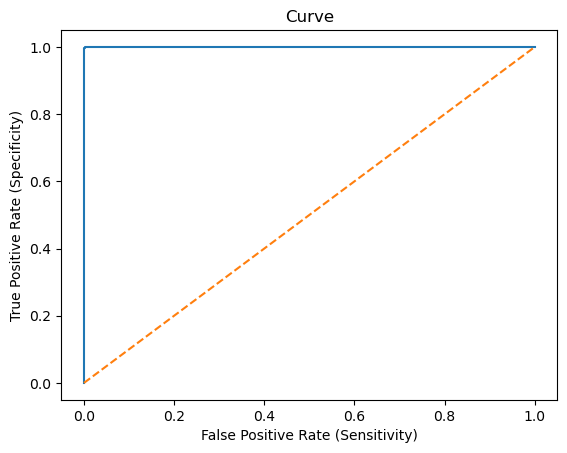


Check Precision-Recall Curve and Average Precision Score


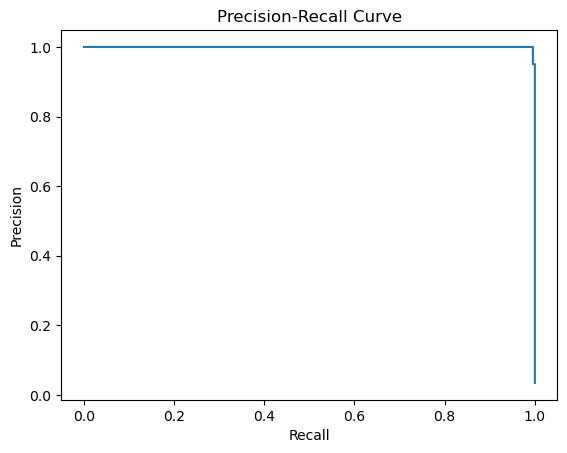

The roc_auc_score:  0.9613780318245018
Average Precision Score:  0.9997862220084442


,class_weight_name,class imbalance class 0,class imbalance class 1,roc_curve_auc,ave_precision_score,data_set
0,None,0.965543,0.034457,0.554113,0.836295,train
1,balanced mode,0.965543,0.034457,0.884289,0.945200,train
2,balanced computed,0.965543,0.034457,0.884289,0.945200,train
3,balanced_and_normalized,0.965543,0.034457,0.961378,0.999786,train


In [31]:
perf_dict_list = []

for class_weight_name, class_weight_option in class_weight_options_dict.items():
    estimator = SGDClassifier(loss=loss, random_state=model_random_state, class_weight=class_weight_option)
    
    composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])
    print(f'', '*' * 60, sep='')
    print(f'\nclass_weight {class_weight_name}')
    roc_auc, ave_precision = \
        bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, 'train sample')
    row_dict = {
        'class_weight_name': class_weight_name,
        'class imbalance class 0': train_y_df.value_counts(normalize=True).loc[0],
        'class imbalance class 1': train_y_df.value_counts(normalize=True).loc[1],
        'roc_curve_auc': roc_auc,
        'ave_precision_score': ave_precision,
        'data_set': 'train'
    }
    perf_dict_list.append(row_dict)
    
perf_dict_df = pd.DataFrame(perf_dict_list)
perf_dict_df

#### 10. Evaluate the performance of the trained default estimators on the validation set

In [32]:
validation_df = pd.read_csv('validation_df_exp.csv')
validation_cap_x_df, validation_y_df = validation_df.drop(columns=target_attr), validation_df[[target_attr]]

Check accuracy score
validation set set accuracy score: 1.0

Check confusion matrix
validation set set confusion matrix: 
[[1618    0]
 [   0   58]]
True Positives =  1618
True Negatives =  58
False Positives(Type I error) =  0
False Negatives(Type II error) =  0

Check classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1618
           1       1.00      1.00      1.00        58

    accuracy                           1.00      1676
   macro avg       1.00      1.00      1.00      1676
weighted avg       1.00      1.00      1.00      1676


Check the ROC Curve and AUC


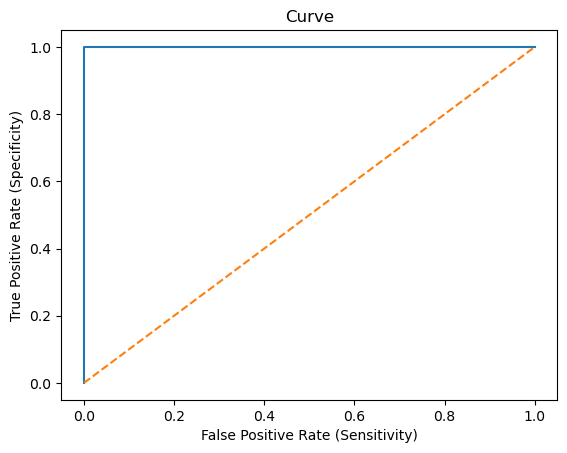


Check Precision-Recall Curve and Average Precision Score


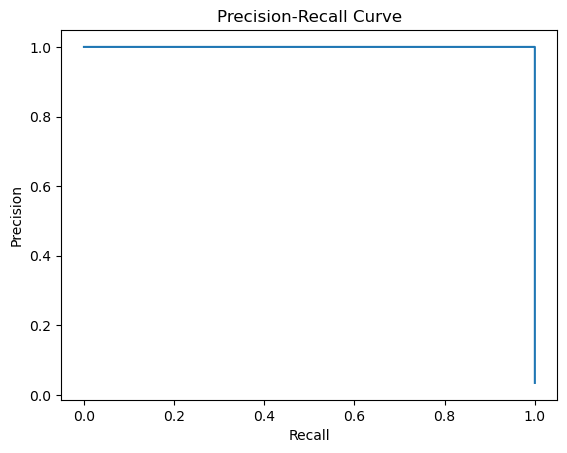

The roc_auc_score:  1.0
Average Precision Score:  1.0


In [33]:
val_estimator = SGDClassifier(loss=loss, random_state=model_random_state, class_weight=None)
    
val_composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', val_estimator)])

val_roc_auc, val_ave_precision = \
    bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, val_composite_estimator, 'validation set')
val_dict_list = {
    'class_weight_name': 'None',
    'roc_curve_auc': val_roc_auc,
    'ave_precision_score': val_ave_precision,
    'data_set': 'validation'
}
val_perf_dict_df = pd.DataFrame([val_dict_list])

In [34]:
# compare the performance on the train and validation set
uncompared_columns = ['class imbalance class 0', 'class imbalance class 1']
best_perf_dict_df = perf_dict_df[perf_dict_df['class_weight_name'] == 'None'].drop(columns = uncompared_columns)
pd.concat([best_perf_dict_df, val_perf_dict_df], ignore_index=True)

,class_weight_name,roc_curve_auc,ave_precision_score,data_set
0,None,0.554113,0.836295,train
1,None,1.000000,1.000000,validation


#### Other steps

In [35]:
print('Distribution in train_y_df\n', train_y_df.value_counts(), '\n')
print('Distribution in validation_y_df\n', validation_y_df.value_counts(), '\n')

Distribution in train_y_df
 label
0    6473
1     231
Name: count, dtype: int64 

Distribution in validation_y_df
 label
0        1618
1          58
Name: count, dtype: int64 

